# Assignment 1 -- Place cells and the basics

In this notebook, we will go through the basics of preparing an environment for performing a data analysis task. 

The first step is to prepare a *conda virtual environment*. This will be a sandboxes Python environment containing exactly the packages you need with exactly the versions you need. The virtual environment will be separated from other virtual environments that you may need for different projects (you may need there a package that requires as a dependency a different version of eg. Numpy than you have here).  

For this exercise we will need: 
- Numpy (the linear algebra extension for Python, this allows us to work with vectors and matrices in a style similar to Matlab. Numpy is eeded for essentially all data analysis task)
- Scipy (for additional scientific functions)
- Matplotlib (basis plotting libraries)
- Jupyter lab or jupyter notebook (to run this notebook)
- ipywidgets (for some interactive visualization

the documentation for these packages (google it!) will be very useful here.

You can either do the assignment in this notebook, or copy the relevant code in a different notebook, or in a Python file ("module" more properly). If you use a notebook, you can add your observations and interpretations of results in the notebook itself using *Markdown* cells, such as this one. Markdown allows you to write nicely formatted text (including math, in a LaTeX style), so that you can have your code and your entire report in one place. You will find a basic tutorial on Markdown [here](https://guides.github.com/features/mastering-markdown/) 

You will find a number of questions in the notebook. Some of them are harder than other. As a rule, I will assign a full grade for ~80% of the questions correctly solved. 

We start by importing the necessary packages 

In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets

## Part 1 -- Simulating place cells 

Place cells are cells in the hippocampus that activate when the animal (typically rat or mouse) passes through a specific place in an environment. Together place cells for a spatial map of the environment that is supposed to support episodic memory. A good review on place cells is the one by [Moser et al](https://www.annualreviews.org/doi/full/10.1146/annurev.neuro.31.061307.090723?url_ver=Z39.88-2003&rfr_id=ori%3Arid%3Acrossref.org&rfr_dat=cr_pub%3Dpubmed). Some more information on the hippocampus [here](http://www.scholarpedia.org/article/Hippocampus#Hippocampal_place_cells_and_episode_cells)

In a typical place cell experiment, multiple hippocampal neurons are recorded at the same time eg. with a multi-tetrode array. For each cell (as a result of the spike sorting process, that we will not cover here) we get the time series of the times of the spikes that each cell emitted. In addition we will get information about the position of the animal at any point in time. Typically, this is obtained by filming the animal movement with a video-camera, and use a video-tracking algorithm to find the animal position in each frame. Thus, we will get a time series with the times of each frame and the position of the animal (X and Y coordinates, or in the case of running on a linear track, only a 1-D coordinate. To find the animal position at the moment of the emission of each spike (which is the basic unit of information for our analysis) we will therefore have to "synchronize and realign" these different types of time series. 


To get started, we will create and analyze some simulated data, where we will have more control. We will first generate "ground truth" firing rate maps, and then simulate spike trains as inhomogeneous Poisson processes, with a rate determined by the current animal position. 
An inhomogeneous Poisson process is a random process where the instantaneous probability to have an event at time $t$ (more precisely, the probability of having an event between times $t$ and $t + dt$ is given by:

$$p(event in [t, t+dt]) = \lambda(t)dt$$

Here we define the parameters for the simulation. We will consider a 1-D environment, such as linear track

In [2]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

The probaility distribution for the place field size has shape

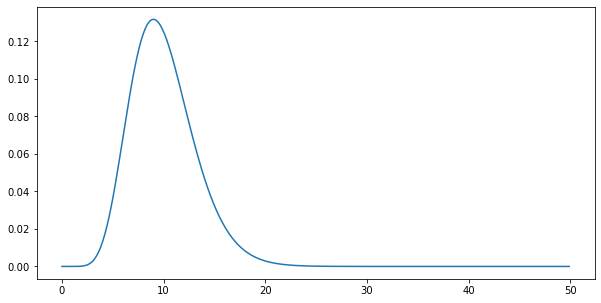

In [3]:
x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)
plt.plot(x, g)

In [4]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

Here is what the true place field maps will look like

Text(0, 0.5, 'cell #')

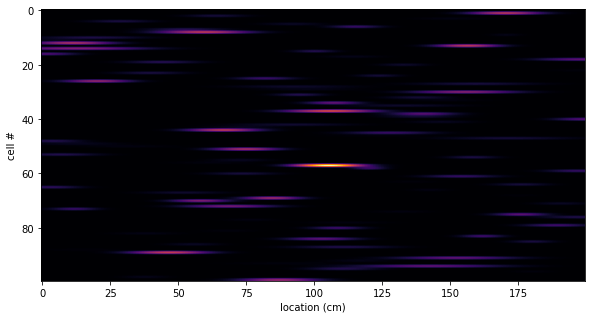

In [5]:
plt.imshow(true_firing_rate_maps, cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')

Now plotting them in the order of place field (common plot type in the field)

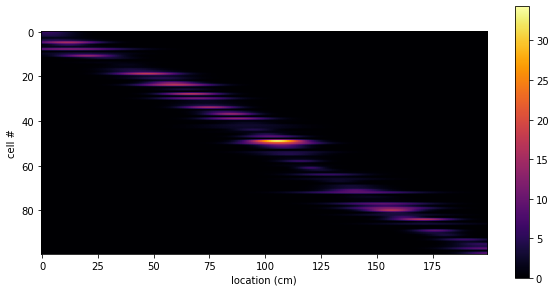

In [6]:
ix = np.argsort(pf_centers)
plt.imshow(true_firing_rate_maps[ix,:], cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

now let's simulate the "mouse" trajectory. The mouse will shuttle back and forth on the linear track and will stop at the two ends to eat. We will make a very rough simulation, in which the running speed will be constant for each run

In [7]:
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps


`t` and `x` are, respectively, the times, and position readouts for all the video frames. This pair represent the first time series that we will encounter in a typical experiment

This is what the mouse trajectory looks like

Text(0, 0.5, 'position on track (cm)')

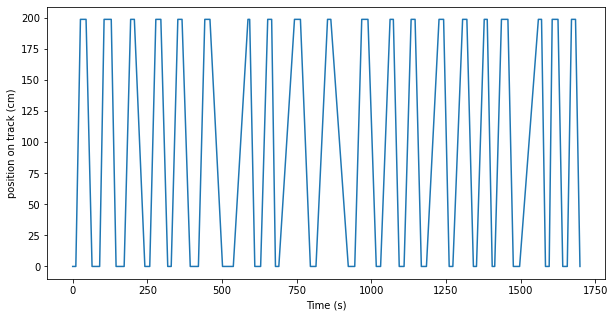

In [8]:
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('position on track (cm)')

The cell below draws spikes according to an inhomogeneous Poisson process. This is the hear of the simulation. Look at the `for` loop, what is each line of code doing?

In [9]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

`spikes` and the pair `t, x` contain the information that we typically get from an experiment. Thus, our analyses will focus on those. 

In the lines below, we plot the positions at which the spikes are fired. 

Note two important things

- the use of `np.interp` (check the documentation!) to realign the spikes and the position time series. That instruction returns a series of the positions at which spikes were fired. This is a key operation that you will perform many times in the context of these analyses 

- the use of `interact` (from `ipywidgets`) to make an interactive plot so that we quickly explore the behavior of all cells



In [10]:
def plot_unit(i):
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

Let's extract this information directly using a typical Python construct, a _list comprehension_ (check the docs if you don't know what that is! Spoiler: it's a handy way to replace a for loop)

In [11]:
spike_positions = [np.interp(s, t, x) for s in spikes]

Now let's make experimental firing rate maps, by taking the histogram of the spikes at each position and normalizing it by the "occupancy" that is, the time at each point on the track.

In [12]:
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

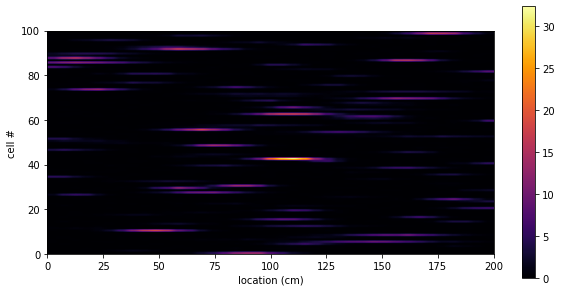

In [13]:
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

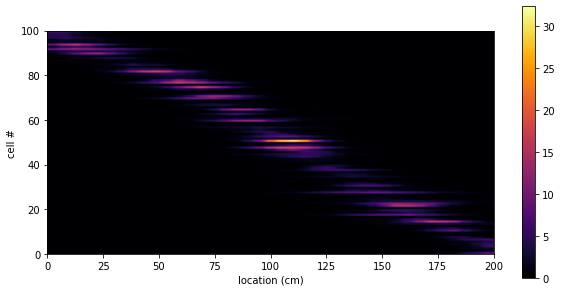

In [14]:
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

## Questions

#### Question 1

Explore what happens when you change the binning in the above definition of the firing rate maps (`space_bins`). Make it coarser or broader. 

#### Question 2

In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


#### Question 3 (OPTIONAL)

We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. Optional: other packages such as Scikit-learn have more sophisticated kernel smoothers. Install that packages and get that smoother to run on the data


#### Question 4

When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 




## Mutual information 

What makes a place cell? We are looking for cells with some amount of spatial selectivity. But how to we define/quantify that precisely?
One way is to use information theory. In particular mutual information is a way to quantify the degree of association between two random variables, such as the firing of an hippocampal cell and the position of a mouse. [Skaggs et al.](https://papers.nips.cc/paper/671-an-information-theoretic-approach-to-deciphering-the-hippocampal-code.pdf) defined a widely used formula to compute this "spatial information"  for the case of place cells. 

$$ I = \sum_x \lambda(x) \log_2 \frac{\lambda(x) + \epsilon}{\lambda} p_{occ}(x) $$ 

Where $\epsilon$ is a very small number (e.g. $10^{-15}$) This small number avoids infinities (and NaNs) when $\lambda(x) = 0$.


where $\lambda(x)$ is the firing rate map (as defined above, with some binning precision) $\lambda$ is the average firing rate of the neuron, and $p_{occ}(x)$ is the occupancy as defined above. Information from this formula is expressed in bits per second. An alternative definition is expressed in bits/spike:

$$ I_s = \frac{I}{\lambda}$$ 

(same formula as above divided by average firing rate). This second definition favors low-firing rate cells (typical for place cells)

## Questions

#### Question 5
Implement this formula, and calculate the mutual information for the cells in the simulation above

#### Question 6 (OPTIONAL)
Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes. 

## Working with real data

After getting the main concepts with the simulations, we can look at some real data. You can find data from my PhD student Matteo Guardamagna at the link you will find on Mattermost. 
Please unzip the data contained here, you will find data from two experiments: one on a linear track (1-D, very similar to the simulations above) and one in a open field. 
the data are contained in matlab files that can be read easily using functions from scipy

Download from that link the file PlaceCellsData.zip and unzip it in a folder (*outside* of your git repo: this is important so that you don't save on github the very large data files). Change to this new extracted folder. In my case:

In [15]:
cd /Users/fpbatta/Dropbox/TeachingRU/Neuroanalysis/Data/place_cells 

/Users/fpbatta/Dropbox/TeachingRU/Neuroanalysis/Data/place_cells


In [16]:
cd 1D

/Users/fpbatta/Dropbox/TeachingRU/Neuroanalysis/Data/place_cells/1D


In [17]:
ls

default.profraw  position.mat     spiketimes.mat


In [18]:
f = scipy.io.loadmat('spiketimes.mat')

We use the following method to put the spike times in the same format as for the simulations

In [19]:
spike_times = f['spike_times']

spikes = [spike_times[0][i].ravel() for i in range(len(spike_times[0]))]

`spikes` is now a list of numpy arrays with the spike time series 

Position data is in the file `position.mat`

In [20]:
f = scipy.io.loadmat('position.mat')

and we use the following method to bring it to the same for as for the simulations

In [21]:
t = f['t'].ravel()
x = f['x'].ravel()

Let's take a look at the data, you will see that is a much more mixed bag than the simulation: there are cells that fire little, there are interneurons (cells that fire a lot, with little spatial selectivity). The same interactive plot as above will help a lot 

In [22]:
def plot_unit(i):
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(len(spikes)-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=107), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_unit(i)>

## Questions

#### Question 7

Reproduce the firing rate maps we produced for the simulation, in proper sorting order.

#### Question 8 

Calculate the mutual information for each cell (both bits/sec and bits/spike)

#### Question 9 (OPTIONAL)

Place related firing only takes place when the animal is running. When the animal is sitting still (which they do a lot as you can see from the trajectory plot), firing becomes non-local. Thus, in place cell analysis it is customary to "filter out" spikes that takes place when the animal is not running. This is a slightly tricky, but important technique. One way to do it would be to 
1. Calculate the instantaneous speed of the mouse. You can do that by calculating the time derivative of position with `np.diff` (check docs!!!), and divide by the video sampling interval (difference between two consecutive timestamps
2. Calculate the speed at the time of each spikes. You can use `np.interp` similar to what we did to calculate position (see above)
3. Use a threshold value of ~ 3 cm/s and exclude the spikes that were emitted while the mouse was not running fast enough

After you've done this, repeat the work in questions 5 and 6 on the "cleaned up" data (it will look a lot nicer)

#### Question 10 (OPTIONAL)
(optional, the trickiest of all) if you look at the interactive plot above, you will notice that many cells fire only in one direction (for example when the mouse is going from 0 to 100 and not vice versa). Calculate a directionality index as the difference between the firing rate in the place field while running in the two directions. First you need to segment time in "upwards" and "downwards" runs (that's the tricky part...) and then subset the spikes run in the two directions/

## 2D Data

Last, we will work form data recorded while the mouse was exploring a 2D environment (square box), this is contained in the `2D` directory from the same zip file. 

In [47]:
cd ../2D

/Users/fpbatta/Dropbox/TeachingRU/Neuroanalysis/Data/place_cells/2D


In [48]:
ls

position.mat    spiketimes.mat


Data loading goes pretty much as in the previous case, except that now there is also a `y` position variable.

In [49]:
f = scipy.io.loadmat('spiketimes.mat')

spikes = [spike_times[0][i].ravel() for i in range(len(spike_times[0]))]

f = scipy.io.loadmat('position.mat')
t = f['t'].ravel()
x = f['x'].ravel()
y = f['y'].ravel()

This is what the mouse trajectory looks like in the arena

(19.858022204499996, 506.1662332855, -7.042710394500002, 486.7634531045)

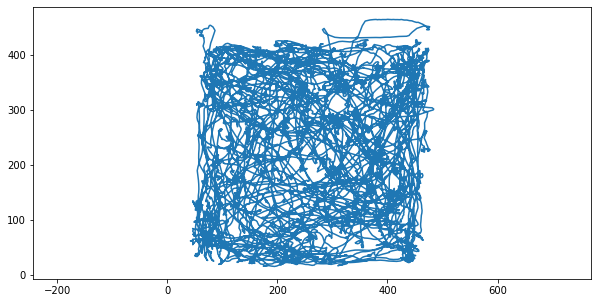

In [50]:
plt.plot(x, y)
plt.axis('equal')

## Questions 

#### Question 11
Compute the firing rate map for each cell, and use eg an interactive plot (if in a notebook) to display them all. You can use the function `np.histogram2d` 

#### Question 12 (OPTIONAL)
Compute the spatial information for each cells. Explore what happens if you make the binning in your histogram too fine. You will at some point hit the so-called "finite sample size bias" problem, on which you can find more information in this paper by [Quian-Quiroga et al](https://www.nature.com/articles/nrn2578)